In [18]:
%matplotlib inline

In [19]:
"""
Dedalus script for 2D tracer advection-diffusion on a slope

This script uses a Fourier basis in the y direction with periodic boundary
conditions.

This script can be ran serially or in parallel, and uses the built-in analysis
framework to save data snapshots in HDF5 files.  The `merge.py` script in this
folder can be used to merge distributed analysis sets from parallel runs,
and the `plot_2d_series.py` script can be used to plot the snapshots.

To run, merge, and plot using 4 processes, for instance, you could use:
    $ mpiexec -n 4 python3 igw.py
    $ mpiexec -n 4 python3 merge.py snapshots
    $ mpiexec -n 4 python3 plot_2d_series.py snapshots/*.h5

"""
import numpy as np
import h5py
import matplotlib
matplotlib.rcParams["figure.facecolor"] = "white"
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"
import matplotlib.pyplot as plt
from mpi4py import MPI
from scipy.special import erf
import time
from IPython import display

from dedalus import public as de
from dedalus.extras import flow_tools

import logging
logger = logging.getLogger(__name__)


In [27]:

# Input Grids and parameters ------------------------------------------------------------
Ly, Lz = (500000., 2000.) # units = 1m

# Create bases and domain
y_basis = de.Fourier('y', 32, interval=(-Ly, Ly), dealias=3/2)
z_basis = de.Chebyshev('z', 32, interval=(0, Lz), dealias=3/2)
domain = de.Domain([y_basis, z_basis], grid_dtype=np.float64)

# Input fields --------------------------------------------------------------------------
y = domain.grid(0)
z = domain.grid(1)

# Upslope Velocity
V = domain.new_field()
sh = 0.0003 # s-1 
V['g'] = sh*z

# Vertical Diffusivity
K0 = 1.0e-5
Kv = domain.new_field()
Kvz = domain.new_field()
d = 500.0
K1 = 1.0e-2
Kv['g'] = K1*np.exp(-z/d)
Kv.differentiate('z',out=Kvz)

# Horizontal Diffusivity
E0 = 100.0
Ev = domain.new_field()
Ev['g'] = 0.0

# Equations and Solver
problem = de.IVP(domain, variables=['tr','trz'])
problem.meta[:]['z']['dirichlet'] = True

problem.parameters['κy']  = 100.0
problem.parameters['Kv'] = Kv
problem.parameters['Kvz'] = Kvz
problem.parameters['K0'] = K0
problem.parameters['Ev'] = Ev
problem.parameters['E0'] = E0
problem.parameters['V']  = V
problem.add_equation("dt(tr) - E0*d(tr,y=2) - K0*dz(trz) = Kv*dz(trz) + Kvz*trz + Ev*d(tr,y=2) - V*dy(tr)")
problem.add_equation("trz - dz(tr) = 0")
problem.add_bc("left(trz) = 0")
problem.add_bc("right(trz) = 0")

# Build solver
solver = problem.build_solver(de.timesteppers.RK222)
logger.info('Solver built')

# Initial condition:
tr = solver.state['tr']
trz = solver.state['trz']

k = 2.0*np.pi/Ly
tr['g'] = np.cos(k*(y-sh*z*86400*20))
tr.differentiate('z',out=trz)

# Integration parameters
solver.stop_sim_time = np.inf
solver.stop_wall_time = 3*60.
solver.stop_iteration = np.inf

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', iter=20, max_writes=50)
snapshots.add_task('tr')

dt=2000.0


2018-03-16 10:24:38,901 pencil 0/1 INFO :: Building pencil matrix 1/16 (~6%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s


2018-03-16 10:24:38,910 pencil 0/1 INFO :: Building pencil matrix 2/16 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s


2018-03-16 10:24:38,925 pencil 0/1 INFO :: Building pencil matrix 4/16 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s


2018-03-16 10:24:38,941 pencil 0/1 INFO :: Building pencil matrix 6/16 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s


2018-03-16 10:24:38,957 pencil 0/1 INFO :: Building pencil matrix 8/16 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s


2018-03-16 10:24:38,976 pencil 0/1 INFO :: Building pencil matrix 10/16 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s


2018-03-16 10:24:38,991 pencil 0/1 INFO :: Building pencil matrix 12/16 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s


2018-03-16 10:24:39,007 pencil 0/1 INFO :: Building pencil matrix 14/16 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s


2018-03-16 10:24:39,023 pencil 0/1 INFO :: Building pencil matrix 16/16 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s


2018-03-16 10:24:39,025 __main__ 0/1 INFO :: Solver built


2018-03-16 10:25:06,030 __main__ 0/1 INFO :: Iterations: 1960


2018-03-16 10:25:06,031 __main__ 0/1 INFO :: Sim end time: 3920000.000000


2018-03-16 10:25:06,031 __main__ 0/1 INFO :: Run time: 26.39 sec


2018-03-16 10:25:06,032 __main__ 0/1 INFO :: Run time: 0.007332 cpu-hr


KeyboardInterrupt: 

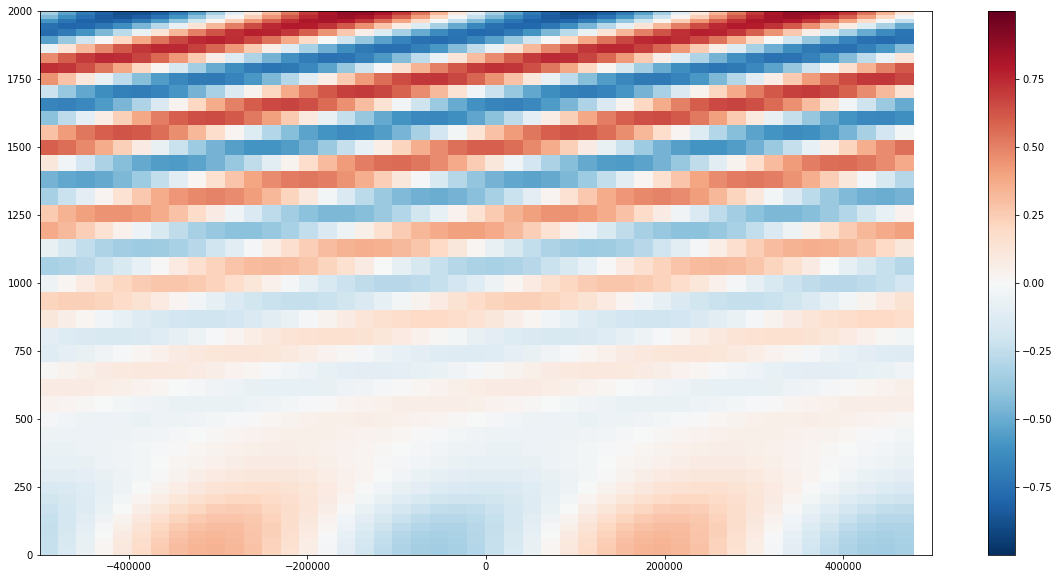

KeyboardInterrupt: 

In [28]:
# Run the model and plot as it runs:
# Make plot of scalar field:
y = domain.grid(0,scales=domain.dealias)
z = domain.grid(1,scales=domain.dealias)
ym, zm = np.meshgrid(y,z)
fig, axis = plt.subplots(figsize=(20,10))
p = axis.pcolormesh(ym, zm, tr['g'].T, cmap='RdBu_r');
plt.colorbar(p, ax = axis)
axis.set_xlim([-Ly,Ly])
axis.set_ylim([0.,Lz])


# Main loop
try:
    logger.info('Starting loop')
    start_time = time.time()
    while solver.ok:
        #        dt = CFL.compute_dt()
        solver.step(dt)
        if (solver.iteration-1) % 100 == 0:
            p.set_array(np.ravel(tr['g'][:-1,:-1].T))
            display.clear_output()
            display.display(plt.gcf())
            logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    end_time = time.time()

    p.set_array(np.ravel(tr['g'][:-1,:-1].T))
    display.clear_output()
    logger.info('Iterations: %i' %solver.iteration)
    logger.info('Sim end time: %f' %solver.sim_time)
    logger.info('Run time: %.2f sec' %(end_time-start_time))
    logger.info('Run time: %f cpu-hr' %((end_time-start_time)/60/60*domain.dist.comm_cart.size))